In [1]:
import yfinance as yf
from pathlib import Path



assets = {"SPX":"^GSPC","GOLD":"GC=F","BTC":"BTC-USD"}
start, end = "2022-01-01","2025-01-01"

# Ensure the raw data directory exists
raw_dir = Path('data/raw')
raw_dir.mkdir(parents=True, exist_ok=True)

for name, ticker in assets.items():
    try:
        print(f"Downloading {name} ({ticker})...")
        df = yf.download(ticker, start=start, end=end)
        df['Close'].to_csv(raw_dir / f"{name}.csv")
        print(f"Saved raw data for {name} to {raw_dir / (name + '.csv')}")
    except Exception as e:
        print(f"Error downloading {name}: {e}")

/var/folders/sr/7d6q0qpj6d38ppqlpgw6vtxh0000gn/T/ipykernel_4743/2555723900.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/sr/7d6q0qpj6d38ppqlpgw6vtxh0000gn/T/ipykernel_4743/2555723900.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)


Saved raw data for SPX to data/raw/SPX.csv


[*********************100%***********************]  1 of 1 completed
/var/folders/sr/7d6q0qpj6d38ppqlpgw6vtxh0000gn/T/ipykernel_4743/2555723900.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)


Saved raw data for GOLD to data/raw/GOLD.csv


[*********************100%***********************]  1 of 1 completed

Saved raw data for BTC to data/raw/BTC.csv


In [2]:
import os
print("Current working dir:", os.getcwd())

# And list whatever’s in data/raw right now:
print("data/raw contains:", os.listdir("data/raw"))

Current working dir: /Users/jivenchana/PycharmProjects/cyber-fractal-entanglement/data
data/raw contains: ['BTC.csv', 'GOLD.csv', 'SPX.csv']


SPX     0
GOLD    0
BTC     0
dtype: int64
Duplicates: 0
Freq: B
SPX     1.267657
GOLD    1.220786
BTC     1.168370
dtype: float64 SPX     2.349120
GOLD    2.291474
BTC     2.398653
dtype: float64
Zero-var assets: SPX     False
GOLD    False
BTC     False
dtype: bool
Extreme FD outliers:
 SPX     0
GOLD    0
BTC     0
dtype: int64
          mean       std      skew      kurt
SPX   1.776826  0.185840  0.054232 -0.065849
GOLD  1.771429  0.221402 -0.072781 -0.388327
BTC   1.812730  0.247776 -0.103711 -0.534049
           SPX      GOLD       BTC
SPX   1.000000 -0.135887  0.195673
GOLD -0.135887  1.000000  0.083052
BTC   0.195673  0.083052  1.000000
SPX ADF p-value: 1.4180330405876239e-05
GOLD ADF p-value: 2.2125069366832027e-15
BTC ADF p-value: 1.3404580196551555e-22


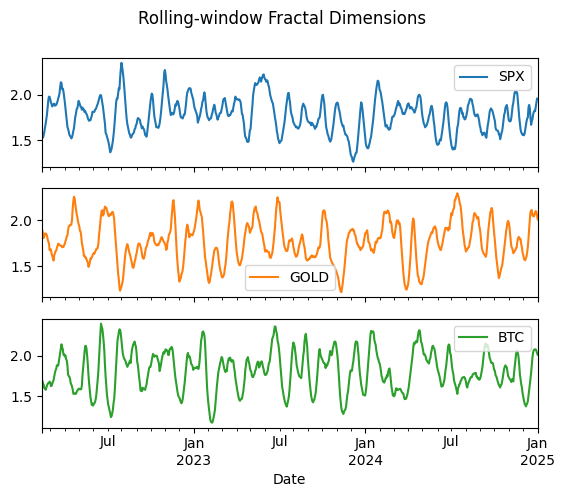

In [5]:
import pandas as pd
df_fd = pd.read_csv("processed/fractals.csv", index_col=0, parse_dates=True)
print(df_fd.isna().sum())
print("Duplicates:", df_fd.index.duplicated().sum())
print("Freq:", df_fd.index.inferred_freq)
print(df_fd.min(), df_fd.max())
print("Zero-var assets:", (df_fd.std()==0))

from scipy.stats import zscore
z = df_fd.apply(zscore)
print("Extreme FD outliers:\n", (z.abs()>5).sum())

stats = pd.DataFrame({
    "mean":   df_fd.mean(),
    "std":    df_fd.std(),
    "skew":   df_fd.skew(),
    "kurt":   df_fd.kurtosis()
})
print(stats)

print(df_fd.corr())
df_fd.plot(subplots=True, title="Rolling-window Fractal Dimensions")

from statsmodels.tsa.stattools import adfuller
for col in df_fd:
    p = adfuller(df_fd[col].dropna())[1]
    print(col, "ADF p-value:", p)


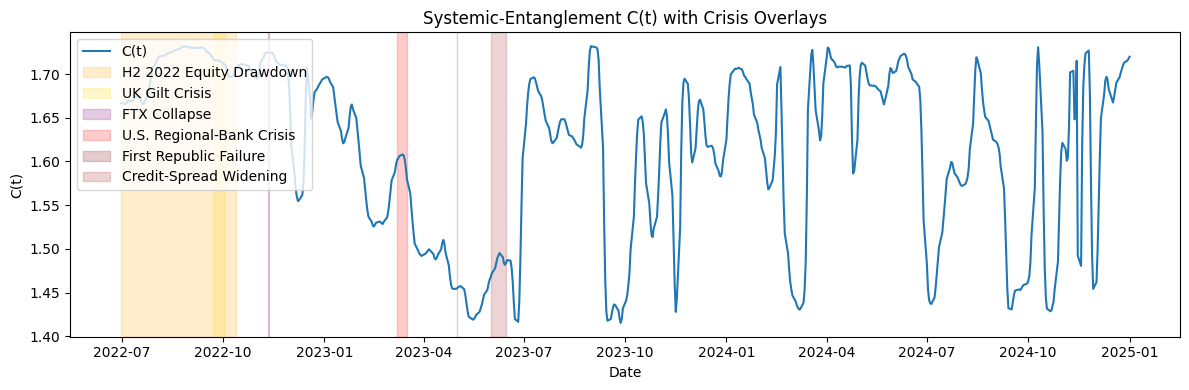

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your C(t)
df_C = pd.read_csv("processed/C_series.csv", index_col=0, parse_dates=True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_C.index, df_C["C"], label="C(t)")

# List of (start, end, color, label)
highlights = [
    ("2022-06-30","2022-10-13","orange","H2 2022 Equity Drawdown"),
    ("2022-09-23","2022-10-03","gold","UK Gilt Crisis"),
    ("2022-11-11","2022-11-12","purple","FTX Collapse"),
    ("2023-03-08","2023-03-17","red","U.S. Regional-Bank Crisis"),
    ("2023-05-01","2023-05-01","maroon","First Republic Failure"),
    ("2023-06-01","2023-06-15","brown","Credit-Spread Widening")
]

for start, end, color, label in highlights:
    ax.axvspan(start, end, color=color, alpha=0.2, label=label)

# Avoid duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper left")

ax.set_title("Systemic-Entanglement C(t) with Crisis Overlays")
ax.set_ylabel("C(t)")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

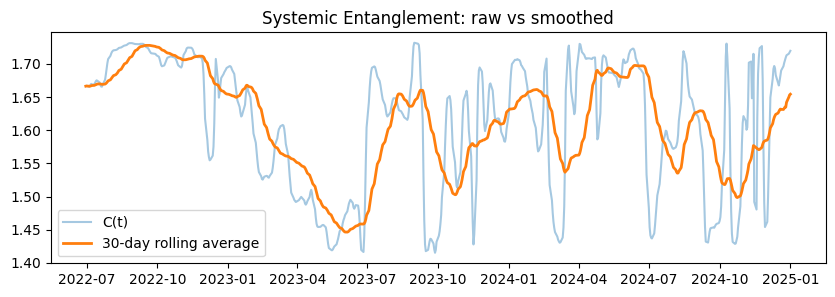

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df_C = pd.read_csv("processed/C_series.csv", index_col=0, parse_dates=True)
df_C["C_smooth"] = df_C["C"].rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(10,3))
plt.plot(df_C.index, df_C["C"],      label="C(t)", alpha=0.4)
plt.plot(df_C.index, df_C["C_smooth"], label="30-day rolling average", linewidth=2)
plt.legend()
plt.title("Systemic Entanglement: raw vs smoothed")
plt.show()

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression

# split
mid = pd.Timestamp("2023-07-01")
pre = df_C.loc[:mid,   "C"].dropna().values.reshape(-1,1)
post= df_C.loc[mid:,   "C"].dropna().values.reshape(-1,1)
t_pre = np.arange(len(pre)).reshape(-1,1)
t_post= np.arange(len(post)).reshape(-1,1)

lm = LinearRegression()
lm.fit(t_pre, pre);  trend_pre  = lm.coef_[0][0]
lm.fit(t_post, post);trend_post = lm.coef_[0][0]

print(f"Trend before Jul 2023: {trend_pre:.4f}/day")
print(f"Trend after  Jul 2023: {trend_post:.4f}/day")

Trend before Jul 2023: -0.0012/day
Trend after  Jul 2023: -0.0000/day


In [14]:
import pandas as pd

# 1) load your original C(t)
df = pd.read_csv("processed/C_series.csv", index_col=0, parse_dates=True)

# 2) smooth or diff
df_sm = df.copy()
df_sm["C"] = df_sm["C"].rolling(3, min_periods=1).mean()
df_sm.to_csv("processed/C_series_smoothed.csv")

df_diff = df.copy()
df_diff["C"] = df_diff["C"].diff().fillna(0)
df_diff.to_csv("processed/C_series_diff.csv")